In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
a2a-sdk 0.3.22 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.1 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.

In [2]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from PIL import Image 
from pathlib import Path

import warnings 
warnings.filterwarnings('ignore') 

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from sklearn.model_selection import train_test_split 
from datasets import load_dataset 
import fasttext 

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-01-27 19:51:29.872595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769543490.081215      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769543490.147130      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769543490.683760      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769543490.683812      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769543490.683815      23 computation_placer.cc:177] computation placer alr

In [3]:
IMAGE_SIZE = (224, 224)  
BATCH_SIZE = 32
LEARNING_RATE = 1e-4  
EPOCHS = 100 


DATA_DIR ='/kaggle/input/smile-detection-sequences/visualizations'

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of batches: {len(dataset)}")

Found 230 files belonging to 2 classes.


I0000 00:00:1769543504.509821      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Class names: ['non_smile', 'smile']
Number of batches: 8


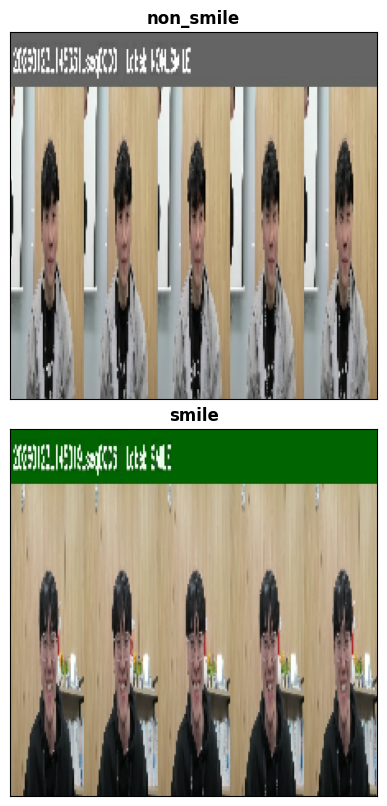

In [5]:
class_images = {}

for images, labels in dataset:
    for img, label in zip(images, labels):
        label = label.numpy()
        if label not in class_images:
            class_images[label] = img.numpy()
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

fig, axes = plt.subplots(
    nrows=num_classes,
    ncols=1,
    figsize=(8, 4 * num_classes),
    subplot_kw={'xticks': [], 'yticks': []}
)

if num_classes == 1:
    axes = [axes]

for i, class_idx in enumerate(sorted(class_images.keys())):
    axes[i].imshow(class_images[class_idx].astype('uint8'))
    axes[i].set_title(f"{class_names[class_idx]}", fontsize=12, fontweight='bold')

plt.tight_layout(pad=0.5)
plt.show()

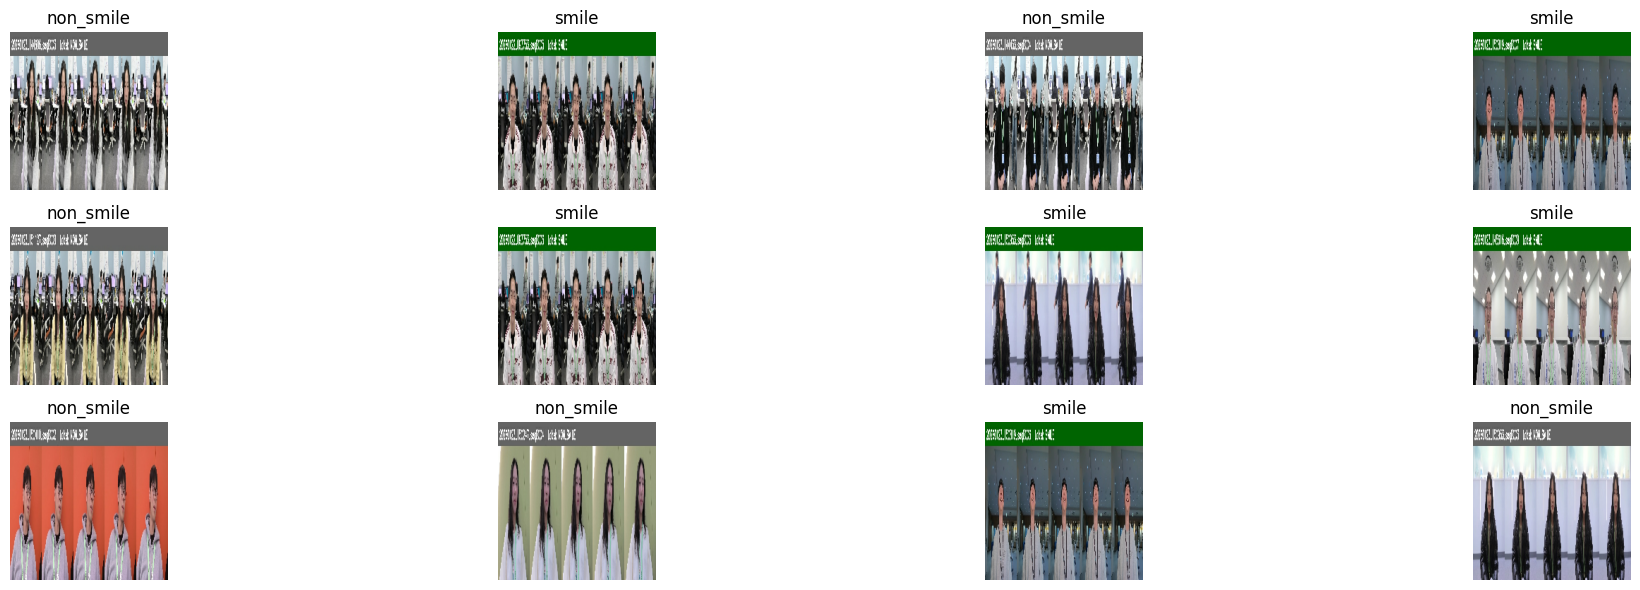

In [6]:
plt.figure(figsize=(22, 6))
for image_batch, label_batch in dataset.take(1):
    num_images = min(12, len(image_batch))
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
def get_dataset_partitions_tf(
    ds,
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    shuffle=True,
    shuffle_size=1000
):
  
    ds = ds.shuffle(shuffle_size, seed=42) if shuffle else ds

    ds_size = tf.data.experimental.cardinality(ds).numpy()

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    print(f"Train batches: {len(train_ds)}, Val batches: {len(val_ds)}, Test batches: {len(test_ds)}")
    
    return train_ds, val_ds, test_ds  


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Train batches: 5, Val batches: 1, Test batches: 2


In [8]:
def encode_labels(x, y):
    return x, tf.keras.utils.to_categorical(y, num_classes=num_classes)

train_ds = train_ds.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess(x), y))

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),  
    layers.RandomZoom(0.15),  
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),  
])

def augment(images, labels):
    return data_augmentation(images, training=True), labels

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)


train_ds = train_ds.cache()
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [11]:
for images, _ in dataset.take(1):
    CHANNELS = images.shape[-1]

input_shape = (*IMAGE_SIZE, CHANNELS)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)


base_model.trainable = False  


for layer in base_model.layers[-50:]:
    layer.trainable = True

print(f"Trainable layers: {sum([1 for layer in base_model.layers if layer.trainable])} / {len(base_model.layers)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Trainable layers: 50 / 154


In [12]:

model = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    base_model,

   
    layers.GlobalAveragePooling2D(),

   
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.4),


    layers.BatchNormalization(),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.3),

   
    layers.Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,608,642 (9.95 MB)

 Trainable params: 2,202,690 (8.40 MB)

 Non-trainable params: 405,952 (1.55 MB)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_smile_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1769543534.437152      77 service.cc:152] XLA service 0x7901f0002810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769543534.437203      77 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769543537.121461      77 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-27 19:52:23.069587: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-27 19:52:23.267864: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1769543551.140988      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proc

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5579 - auc: 0.5814 - loss: 0.9394 - precision: 0.5579 - recall: 0.5579

5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.5514 - auc: 0.5772 - loss: 0.9456 - precision: 0.5514 - recall: 0.5514 - val_accuracy: 0.6667 - val_auc: 0.7222 - val_loss: 0.7217 - val_precision: 0.6667 - val_recall: 0.6667 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5050 - auc: 0.4715 - loss: 1.0145 - precision: 0.5050 - recall: 0.5050 - val_accuracy: 0.4688 - val_auc: 0.3701 - val_loss: 0.9856 - val_precision: 0.4688 - val_recall: 0.4688 - learning_rate: 1.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.5354 - auc: 0.4913 - loss: 1.1480 - precision: 0.5354 - recall: 0.5354 - val_accuracy: 0.5938 - val_auc: 0.5547 - val_loss: 0.8346 - val_precision: 0.5938 - val_recall: 0.5938 - learning_rate: 1.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4745 - auc: 0.4613 - loss: 1.0799 - precision: 0.4745 - recall: 0.4745
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05

In [15]:
results = model.evaluate(test_ds, return_dict=True)

print("\nTest Set Evaluation")
print("=" * 50)
for metric, value in results.items():
    print(f"{metric.capitalize():<20}: {value:.4f}")
print("=" * 50)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4792 - auc: 0.4092 - loss: 0.9896 - precision: 0.4792 - recall: 0.4792 

Test Set Evaluation
Accuracy            : 0.4844
Auc                 : 0.4331
Loss                : 0.9548
Precision           : 0.4844
Recall              : 0.4844


In [16]:
def plot_training_history(history):
    history = history.history
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['auc'], label='Train AUC', marker='o')
    plt.plot(epochs, history['val_auc'], label='Val AUC', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training vs Validation AUC')
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    best_epoch = history['val_auc'].index(max(history['val_auc'])) + 1

    print("\nTraining Summary")
    print("=" * 40)
    print(f"Epochs trained        : {len(epochs)}")
    print(f"Best Val AUC          : {max(history['val_auc']):.4f}")
    print(f"Best Epoch            : {best_epoch}")
    print(f"Final Train AUC       : {history['auc'][-1]:.4f}")
    print(f"Final Val AUC         : {history['val_auc'][-1]:.4f}")
    print(f"Final Train Loss      : {history['loss'][-1]:.4f}")
    print(f"Final Val Loss        : {history['val_loss'][-1]:.4f}")
    print("=" * 40)


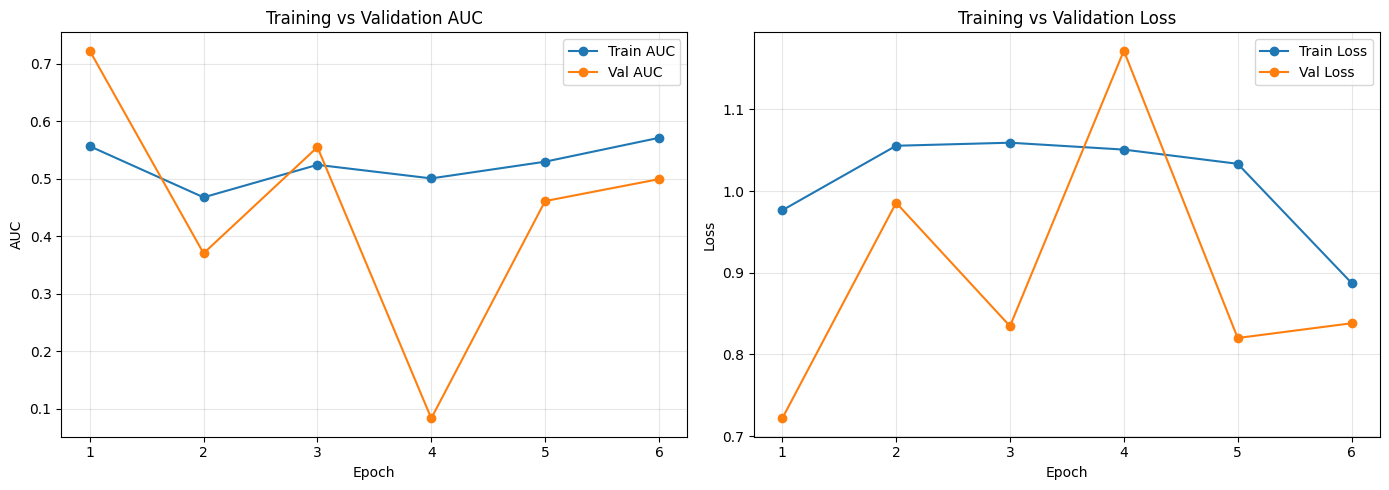


Training Summary
Epochs trained        : 6
Best Val AUC          : 0.7222
Best Epoch            : 1
Final Train AUC       : 0.5708
Final Val AUC         : 0.4990
Final Train Loss      : 0.8875
Final Val Loss        : 0.8381


In [17]:
plot_training_history(history)